# Citation

Samaneh Mahdavifar, Amgad Hanafy Salem, Princy Victor, Miguel Garzon, Amir H. Razavi, Natasha Hellberg, Arash Habibi Lashkari, “Lightweight Hybrid Detection of Data Exfiltration using DNS based on Machine Learning”, The 11th IEEE International Conference on Communication and Network Security (ICCNS), Dec. 3-5, 2021, Beijing Jiaotong University, Weihai, China.

In [2]:
import re
import pandas as pd
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# 1. Load heavy stateless DNS data

Load each csv file into a corresponding dataframe*

* Heavy stateless data has 3 benign csv files that will be concatenated into a single dataframe

In [3]:
stateful_light_audio = pd.read_csv("../../../../datasets/CICBELLEXFDNS2021/Light/Attacks/stateful_features-light_audio.pcap.csv")
stateful_light_audio['Category'] = "Audio"
stateful_light_compressed = pd.read_csv("../../../../datasets/CICBELLEXFDNS2021/Light/Attacks/stateful_features-light_compressed.pcap.csv")
stateful_light_compressed['Category'] = "Compressed"
stateful_light_exe = pd.read_csv("../../../../datasets/CICBELLEXFDNS2021/Light/Attacks/stateful_features-light_exe.pcap.csv")
stateful_light_exe['Category'] = "Exe"
stateful_light_image = pd.read_csv("../../../../datasets/CICBELLEXFDNS2021/Light/Attacks/stateful_features-light_image.pcap.csv")
stateful_light_image['Category'] = "Image"
stateful_light_text = pd.read_csv("../../../../datasets/CICBELLEXFDNS2021/Light/Attacks/stateful_features-light_text.pcap.csv")
stateful_light_text['Category'] = "Text"
stateful_light_video = pd.read_csv("../../../../datasets/CICBELLEXFDNS2021/Light/Attacks/stateful_features-light_video.pcap.csv")
stateful_light_video['Category'] = "Video"

stateful_light_benign = '../../../../datasets/CICBELLEXFDNS2021/Light/Benign/'

# Use regex to get stateful benign data only
stateful_light_benign_list = [f"{stateful_light_benign}{f}" for f in listdir(stateful_light_benign) if isfile(join(stateful_light_benign, f)) and re.search("^stateful", f) != None]

stateful_light_benign_df = pd.concat(map(pd.read_csv, stateful_light_benign_list), ignore_index=True)
stateful_light_benign_df['Category'] = "Benign"
stateful_light_benign_df['Class'] = "Benign"

In [4]:
stateful_light_malicious = pd.concat(
    [
        stateful_light_audio,
        stateful_light_compressed,
        stateful_light_exe,
        stateful_light_image,
        stateful_light_text,
        stateful_light_video,
    ],
    axis=0,
    ignore_index=True
)

stateful_light_malicious['Class'] = 'Malicious'

In [5]:
stateful_light_data = pd.concat(
    [
        stateful_light_malicious,
        stateful_light_benign_df
    ],
    axis=0,
    ignore_index=True
)

stateful_light_data = stateful_light_data.sample(frac=1).reset_index(drop=True)

In [6]:
stateful_light_data

,rr,A_frequency,NS_frequency,CNAME_frequency,SOA_frequency,NULL_frequency,PTR_frequency,HINFO_frequency,MX_frequency,TXT_frequency,...,unique_country,unique_asn,distinct_domains,reverse_dns,a_records,unique_ttl,ttl_mean,ttl_variance,Category,Class
0,1.0,1,0,0,0,0,0,0,0,0,...,set(),set(),{},unknown,0,[128],128.0,0.0,Benign,Benign
1,0.0,0,0,0,0,0,2,0,0,0,...,set(),set(),{},unknown,0,"[1, 1]",1.0,0.0,Benign,Benign
2,2.0,2,0,0,0,0,0,0,0,0,...,{'US'},{'AS15169'},{'34.95.113.34': {'a10.com'}},34.113.95.34.bc.googleusercontent.com,0,"[128, 122]",125.0,9.0,Benign,Benign
3,0.0,0,0,0,0,0,2,0,0,0,...,set(),set(),{},unknown,0,"[1, 1]",1.0,0.0,Benign,Benign
4,4.0,4,0,0,0,0,0,0,0,0,...,{'US'},{'AS16509'},{'176.34.60.200': {'www.poitan.net'}},www.poitan.net,0,"[128, 128, 122, 122]",125.0,9.0,Benign,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34058,4.0,4,0,0,0,0,0,0,0,0,...,{'RU'},{'AS50340'},{'95.213.188.194': {'www.stolplit.ru'}},stolplit.ru,0,"[128, 128, 122, 122]",125.0,9.0,Benign,Benign
34059,0.0,0,0,0,0,0,6,0,0,0,...,set(),set(),{},unknown,0,"[1, 1, 1, 1, 1, 1]",1.0,0.0,Compressed,Malicious
34060,0.0,0,0,0,0,0,4,0,0,0,...,set(),set(),{},unknown,0,"[1, 1, 1, 1]",1.0,0.0,Benign,Benign
34061,2.0,2,0,0,0,0,0,0,0,0,...,set(),set(),{},unknown,0,"[128, 128]",128.0,0.0,Benign,Benign


# 2. Exploratory Data Analysis (EDA)

In [7]:
stateful_light_data.head()

,rr,A_frequency,NS_frequency,CNAME_frequency,SOA_frequency,NULL_frequency,PTR_frequency,HINFO_frequency,MX_frequency,TXT_frequency,...,unique_country,unique_asn,distinct_domains,reverse_dns,a_records,unique_ttl,ttl_mean,ttl_variance,Category,Class
0,1.0,1,0,0,0,0,0,0,0,0,...,set(),set(),{},unknown,0,[128],128.0,0.0,Benign,Benign
1,0.0,0,0,0,0,0,2,0,0,0,...,set(),set(),{},unknown,0,"[1, 1]",1.0,0.0,Benign,Benign
2,2.0,2,0,0,0,0,0,0,0,0,...,{'US'},{'AS15169'},{'34.95.113.34': {'a10.com'}},34.113.95.34.bc.googleusercontent.com,0,"[128, 122]",125.0,9.0,Benign,Benign
3,0.0,0,0,0,0,0,2,0,0,0,...,set(),set(),{},unknown,0,"[1, 1]",1.0,0.0,Benign,Benign
4,4.0,4,0,0,0,0,0,0,0,0,...,{'US'},{'AS16509'},{'176.34.60.200': {'www.poitan.net'}},www.poitan.net,0,"[128, 128, 122, 122]",125.0,9.0,Benign,Benign


In [8]:
stateful_light_data.columns

Index(['rr', 'A_frequency', 'NS_frequency', 'CNAME_frequency', 'SOA_frequency',
       'NULL_frequency', 'PTR_frequency', 'HINFO_frequency', 'MX_frequency',
       'TXT_frequency', 'AAAA_frequency', 'SRV_frequency', 'OPT_frequency',
       'rr_type', 'rr_count', 'rr_name_entropy', 'rr_name_length',
       'distinct_ns', 'distinct_ip', 'unique_country', 'unique_asn',
       'distinct_domains', 'reverse_dns', 'a_records', 'unique_ttl',
       'ttl_mean', 'ttl_variance', 'Category', 'Class'],
      dtype='object')

In [9]:
stateful_light_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34063 entries, 0 to 34062
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rr                34063 non-null  float64
 1   A_frequency       34063 non-null  int64  
 2   NS_frequency      34063 non-null  int64  
 3   CNAME_frequency   34063 non-null  int64  
 4   SOA_frequency     34063 non-null  int64  
 5   NULL_frequency    34063 non-null  int64  
 6   PTR_frequency     34063 non-null  int64  
 7   HINFO_frequency   34063 non-null  int64  
 8   MX_frequency      34063 non-null  int64  
 9   TXT_frequency     34063 non-null  int64  
 10  AAAA_frequency    34063 non-null  int64  
 11  SRV_frequency     34063 non-null  int64  
 12  OPT_frequency     34063 non-null  int64  
 13  rr_type           34063 non-null  object 
 14  rr_count          34063 non-null  int64  
 15  rr_name_entropy   34063 non-null  float64
 16  rr_name_length    34063 non-null  int64 

Show unique DNS exfiltration categories and their respective counts

In [10]:
stateful_light_data['Category'].value_counts()

Category
Benign        22768
Audio          4246
Compressed     2904
Exe            1836
Video          1245
Text            921
Image           143
Name: count, dtype: int64

Show unique DNS exfiltration classes and their respective counts

In [11]:
stateful_light_data['Class'].value_counts()

Class
Benign       22768
Malicious    11295
Name: count, dtype: int64

Check for NaN values

In [12]:
stateful_light_data.isna().any()

rr                  False
A_frequency         False
NS_frequency        False
CNAME_frequency     False
SOA_frequency       False
NULL_frequency      False
PTR_frequency       False
HINFO_frequency     False
MX_frequency        False
TXT_frequency       False
AAAA_frequency      False
SRV_frequency       False
OPT_frequency       False
rr_type             False
rr_count            False
rr_name_entropy     False
rr_name_length      False
distinct_ns         False
distinct_ip         False
unique_country      False
unique_asn          False
distinct_domains    False
reverse_dns         False
a_records           False
unique_ttl          False
ttl_mean            False
ttl_variance        False
Category            False
Class               False
dtype: bool

Show NaN value counts for each column

In [13]:
stateful_light_data.isna().sum()

rr                  0
A_frequency         0
NS_frequency        0
CNAME_frequency     0
SOA_frequency       0
NULL_frequency      0
PTR_frequency       0
HINFO_frequency     0
MX_frequency        0
TXT_frequency       0
AAAA_frequency      0
SRV_frequency       0
OPT_frequency       0
rr_type             0
rr_count            0
rr_name_entropy     0
rr_name_length      0
distinct_ns         0
distinct_ip         0
unique_country      0
unique_asn          0
distinct_domains    0
reverse_dns         0
a_records           0
unique_ttl          0
ttl_mean            0
ttl_variance        0
Category            0
Class               0
dtype: int64

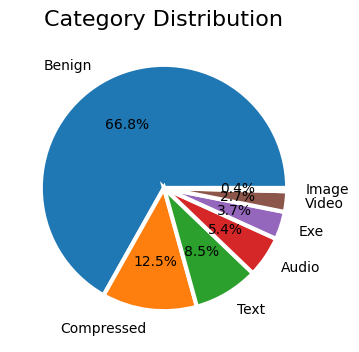

In [14]:
labels = stateful_light_data['Category'].unique()
values = stateful_light_data['Category'].value_counts()

plt.figure(figsize=(5,4))
plt.pie(values, labels=labels, labeldistance=1.15, wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' }, autopct='%1.1f%%')
plt.title("Category Distribution", size=16)
plt.show()

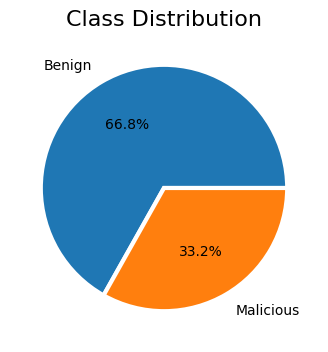

In [15]:
labels = stateful_light_data['Class'].unique()
values = stateful_light_data['Class'].value_counts()

plt.figure(figsize=(5,4))
plt.pie(values, labels=labels, labeldistance=1.15, wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' }, autopct='%1.1f%%')
plt.title("Class Distribution", size=16)
plt.show()

# 3. Data preparation

1. Separate features from labels
2. Remove timestamps to prevent ML overfitting
3. Use target encoding for categorical columns
4. Encode labels
5. (Optional) Normalize data using [StandardScaler](https://www.geeksforgeeks.org/machine-learning/what-is-standardization-in-machine-learning/)

## 3.1. Separate features from labels

In [16]:
X_stateful_light_data = stateful_light_data.drop(['Class'], axis=1)
y_stateful_light_data = stateful_light_data['Class']

## 3.2. Remove timestamps to prevent ML overfiting

In [17]:
X_stateful_light_data.drop(['Category'], axis=1, inplace=True)

In [18]:
X_stateful_light_data.head()

,rr,A_frequency,NS_frequency,CNAME_frequency,SOA_frequency,NULL_frequency,PTR_frequency,HINFO_frequency,MX_frequency,TXT_frequency,...,distinct_ns,distinct_ip,unique_country,unique_asn,distinct_domains,reverse_dns,a_records,unique_ttl,ttl_mean,ttl_variance
0,1.0,1,0,0,0,0,0,0,0,0,...,0,set(),set(),set(),{},unknown,0,[128],128.0,0.0
1,0.0,0,0,0,0,0,2,0,0,0,...,0,set(),set(),set(),{},unknown,0,"[1, 1]",1.0,0.0
2,2.0,2,0,0,0,0,0,0,0,0,...,1,set(),{'US'},{'AS15169'},{'34.95.113.34': {'a10.com'}},34.113.95.34.bc.googleusercontent.com,0,"[128, 122]",125.0,9.0
3,0.0,0,0,0,0,0,2,0,0,0,...,0,set(),set(),set(),{},unknown,0,"[1, 1]",1.0,0.0
4,4.0,4,0,0,0,0,0,0,0,0,...,1,set(),{'US'},{'AS16509'},{'176.34.60.200': {'www.poitan.net'}},www.poitan.net,0,"[128, 128, 122, 122]",125.0,9.0


## 3.3. Target encoding categorical columns

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import TargetEncoder

Check unique value count in categorical columns in feature data

In [20]:
categorical_columns = X_stateful_light_data.select_dtypes(include='object').columns
for column in categorical_columns:
    print(f"Column: {column}, unique values: {len(X_stateful_light_data[column].unique())}")

Column: rr_type, unique values: 5
Column: distinct_ip, unique values: 1
Column: unique_country, unique values: 115
Column: unique_asn, unique values: 1515
Column: distinct_domains, unique values: 9208
Column: reverse_dns, unique values: 4562
Column: unique_ttl, unique values: 59


Target encode categorical columns

In [21]:
encoder = TargetEncoder(
    categories='auto',
    target_type='binary',  # Categorize between Benign and Malicious
    smooth='auto',
    cv=5,
    random_state=42
)

In [22]:
categorical_columns = X_stateful_light_data.select_dtypes(include='object').columns
categorical_columns

Index(['rr_type', 'distinct_ip', 'unique_country', 'unique_asn',
       'distinct_domains', 'reverse_dns', 'unique_ttl'],
      dtype='object')

In [23]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_stateful_light_data, y_stateful_light_data, test_size=0.2, random_state=42)

In [24]:
%%time

X_train[categorical_columns] = encoder.fit_transform(X_train[categorical_columns], y_train)

CPU times: user 138 ms, sys: 1.93 ms, total: 140 ms
Wall time: 141 ms


In [25]:
%%time

X_test[categorical_columns] = encoder.transform(X_test[categorical_columns])

CPU times: user 41.3 ms, sys: 0 ns, total: 41.3 ms
Wall time: 40.9 ms


## 3.4. Encode labels

In [26]:
from sklearn.preprocessing import LabelEncoder

In [27]:
le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

In [28]:
X_train.shape, y_train.shape

((27250, 27), (27250,))

In [31]:
X_test.shape, y_test.shape

((6813, 27), (6813,))

## 3.5. Normalize data

In [32]:
from sklearn.preprocessing import StandardScaler

In [33]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# 4. Model training

XGBoost will be trained and tested on heavy stateless data

## 4.1. Training

In [34]:
%%time

model = xgb.XGBClassifier()
model.fit(X_train, y_train)

CPU times: user 786 ms, sys: 63.4 ms, total: 849 ms
Wall time: 179 ms


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


## 4.2. Testing

In [35]:
%%time

y_pred = model.predict(X_test)

CPU times: user 58.6 ms, sys: 0 ns, total: 58.6 ms
Wall time: 10.5 ms


In [36]:
from sklearn.metrics import accuracy_score, root_mean_squared_error, mean_squared_error, mean_absolute_error, precision_score, confusion_matrix, multilabel_confusion_matrix, classification_report, f1_score, precision_score, recall_score

In [37]:
results_dict = {}

accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

results = [accuracy, precision, f1, recall, mae, mse, rmse]
results_dict["XGB_heavy_stateful"] = results

pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MAE", "MSE", "RMSE"])

,Accuracy,Precision,F1,Recall,MAE,MSE,RMSE
XGB_heavy_stateful,0.801116,0.86764,0.806649,0.801116,0.198884,0.198884,0.445965


# 5. Hyperparameter tuning

Hyperparameter tuning using optuna

In [38]:
pass

# 6. Save model

In [39]:
import pickle

In [40]:
dir = '../../../../models/CICBELLEXFDNS2021/light/stateful/'

with open(f'{dir}XGB_light_stateful.pkl', 'wb') as f:
    pickle.dump(model, f)